![📷 Dettifoss, Island](island.jpg){fig-align="center" width="90%"}

# Hydrologiprosjekt

Her kjem eit døme på korleis ein kan bruka og behandla nokre av dei store hydrologi-datamengdene me har tilgjengeleg i Noreg. Datamaterialet er samla inn av [NVE](https://www.nve.no/) og henta frå [Sildre](https://sildre.nve.no/). 

📌 I det følgjande dømet nyttar eg vassføringsdata frå [Reinsnosvatn](https://www.norgeskart.no/#!?project=norgeskart&layers=1002&zoom=11&lat=6674836.62&lon=34802.80&sok=Reinsnosvatn&markerLat=6675824.352100712&markerLon=36873.4684766499&p=searchOptionsPanel)

> Målestasjonen ligger i Ullensvang i Vestland og er aktiv. Den har vært i drift siden juni 1917 og leverer i dag 3 forskjellige målinger. (sildre.nve.no)

Prosjektet tek altså utgangspunkt i daglege målingar frå 1917! 

::: {.callout-tip collapse="true"}
## Tips til nedlasting

1️⃣ Finn deg ei elv på [sildre.nve.no](https://sildre.nve.no) <br>
2️⃣ Trykk på `last ned som csv` <br>
3️⃣ Kryss av på aktuelle instillingar <br>
4️⃣ Last ned

![⬇️ Laste ned data](laste_ned.jpg){fig-align="center"}

:::


## Importere bibliotek

Vassføringsdataa er lasta ned i csv-format. Me bruker `pandas` for å jobba med dette effektivt. I tillegg vert det litt plotting og matematikk, så me treng `pyplot` og `numpy` i tillegg. 


In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Opprette dataramme

CSV-fila med vassføringsdata les me inn i ei `dataramme` (*dataframe*). Viss ein tar ein kikk på fila ser ein at det er brukt semikolon for å skilja verdiane, det er to rader før verdiane kjem. Me lagar litt forenkla namn på kolonnene, og les inn data. I tillegg er det nytta komma (og ikkje punktum) som desimalteikn. 

![🔍 Dei første linjene](df.jpg){fig-align="center"}

In [80]:
df = pd.read_csv(
    "vassforing_reinsnos_dogn.csv", 
    sep = ";", 
    skiprows = 2, 
    names = ["dato", "Vassføring", "Korrigert", "Kontrollert"], 
    parse_dates = True, 
    decimal=","
)

df.index = pd.to_datetime(df['dato']) 
df.index = pd.to_datetime(df.index.date)
df = df.drop(columns = ["dato", "Korrigert", "Kontrollert"])

Sjekkar dei nyaste fem målingane i tabellen for å sjå at alt ser ok ut. 

In [81]:
df.tail()

,Vassføring
2023-01-24,1.299365
2023-01-25,1.593457
2023-01-26,2.128418
2023-01-27,2.322153
2023-01-28,2.324195


I tillegg kan me prøva å plotta verdiane i dataramma.

<AxesSubplot:>

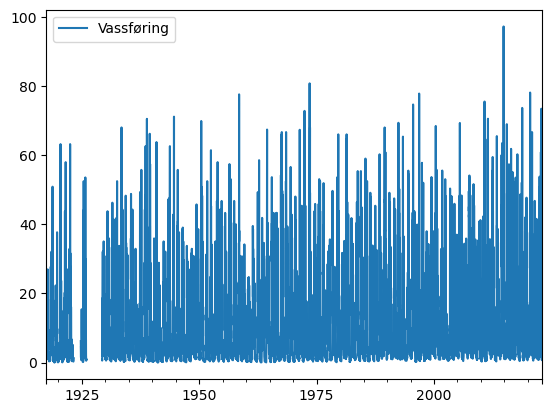

In [82]:
df.plot()

Me ser her at dette ikkje er spesielt nyttig eller informativt, men grafen viser oss at det på 1920-talet er eit par år utan målingar. Korleis dette kan fiksast kjem me attende til litt seinare. 

## Middelflom

Middelflommen til ei elv er rekna ut frå den største døgnvassføringa per år over eit lengre tidsrom. Frå [NVE/varsom.no](https://varsom.no/flom-og-jordskred/ordliste/ordliste-for-flom/) finn me denne definisjonen:

> En middelflom (normal flom) defineres som gjennomsnittet av høyeste vannføring hvert år i en lang årrekke.

For å rekna ut dette må me altså først finna den maksimale vassføringa per år. Bruker `groupby` i Pandas for å finne dette.

In [83]:
årleg_maks = df.groupby(by=[df.index.year]).max()
årleg_maks.head()

,Vassføring
1917,26.98031
1918,50.93218
1919,37.72713
1920,63.26006
1921,58.04514


Plottar den nye dataramma `årleg_maks` som kun har ei måling per år:

<AxesSubplot:>

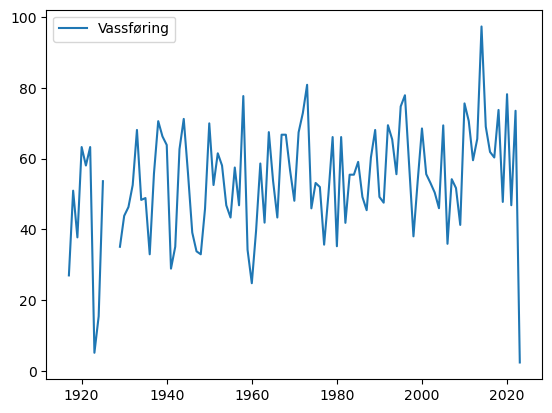

In [84]:
årleg_maks.plot()

På grunn av "holet" i målingane tar me berre med data frå 1930 eller seinare med oss vidare. I tillegg er det vinter (og snø/is) for dataa me har for 2023, så me avgrensar til 2022. 

In [85]:
årleg_maks = årleg_maks.loc[1930:2022]
årleg_maks.head()

,Vassføring
1930,43.82251
1931,46.29647
1932,52.52979
1933,68.09634
1934,48.32775


Me vil finna gjennomsnittleg største årlege vassføring over fleire år. Vel her å sjå på eit gjennomsnitt på 30 år om gongen. Bruker funksjonen `rolling` og `mean` i kombinasjon. `rolling` gjer at me kan gå gjennom dataramma og sjå på dei 30 tidlegare verdiane til kvar rad i tabellen og finna gjennomsnittet (`mean`) i dette rullande vinduet.

In [86]:
maks_og_middelflom = årleg_maks.copy()
maks_og_middelflom["Middelflom"] = årleg_maks.rolling(window = 30).mean()

In [87]:
maks_og_middelflom.head()

,Vassføring,Middelflom
1930,43.82251,NaN
1931,46.29647,NaN
1932,52.52979,NaN
1933,68.09634,NaN
1934,48.32775,NaN


Ser at dei fem første radene i den nye dataramma er `NaN` (not a number). Dette skjer fordi ein ikkje kan ta gjennomsnitt av dei siste 30 åra før det har gått 30 år... Sjekkar dei nyaste åra heller:

In [88]:
maks_og_middelflom.tail()

,Vassføring,Middelflom
2018,73.75180,60.571163
2019,47.75206,59.893282
2020,78.19958,60.860965
2021,46.81937,60.837067
2022,73.51824,60.972971


Plottar dataramma og ser korleis dei nye verdiane ser ut:

<AxesSubplot:>

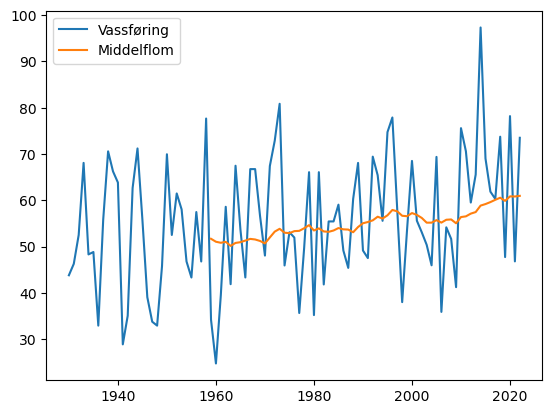

In [89]:
maks_og_middelflom.plot()

## Modellering av middelflom

Ser at trenden er oppadgåande. Ønsker å laga ein lineær modell. Bruker `polyfit` frå `NumPy`. 

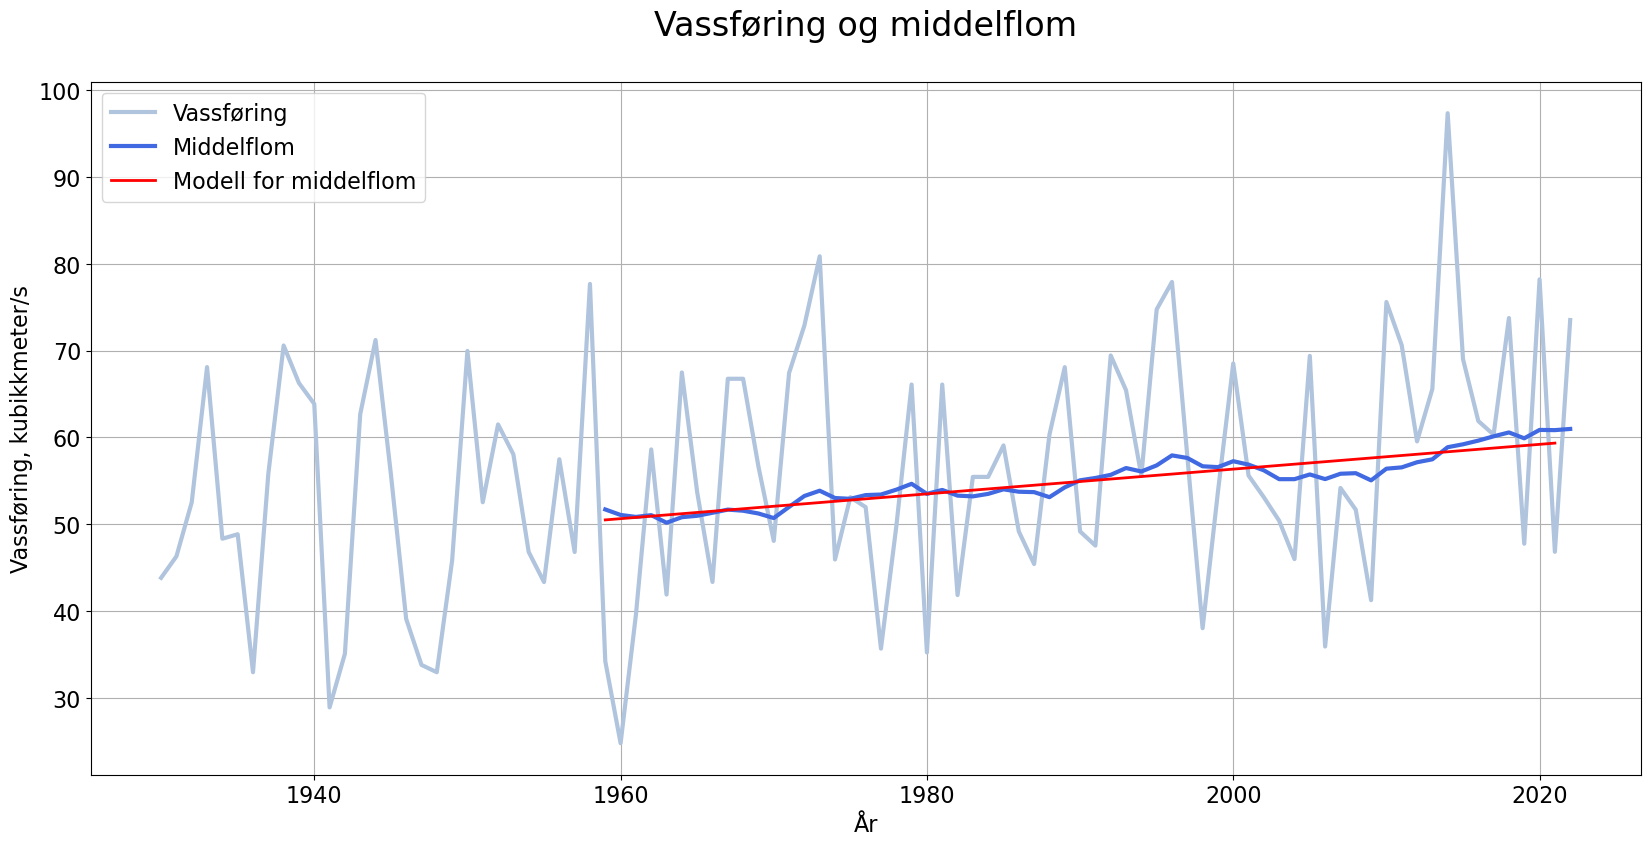

In [90]:
# åra me har data på middelflom
x = np.arange(1959, 2022)

# finn koeffesientane til førstegradspolynomet
a, b = np.polyfit(x, maks_og_middelflom["Middelflom"].loc[1959:2021], 1)

# definerer lineær funksjon
def f(x):
    return a*x + b

# plottar dataramma
maks_og_middelflom.plot(
    figsize = (20,9), 
    grid = True, 
    fontsize = 16, 
    linewidth = 3, 
    color = ["lightsteelblue", "royalblue"]
)

# plottar modellen
plt.plot(
    x, f(x), 
    linewidth = 2, 
    label = "Modell for middelflom", 
    color = "red"
)

# pynting av plot
plt.title("Vassføring og middelflom\n", fontsize = 24)
plt.legend(fontsize = 16)
plt.ylabel("Vassføring, kubikkmeter/s", fontsize = 16)
plt.xlabel("År", fontsize = 16)
#plt.savefig("Reinsnos - årleg maksvassføring og middelflom.png", dpi = 300)
plt.show()

**Ekstrapolasjon - modell for framtidig middelflom**

Me kan bruka trendlinja for middelflommen som modell for å seie noko om korleis utviklinga vil vera i åra framover (om utviklinga held fram som no): 

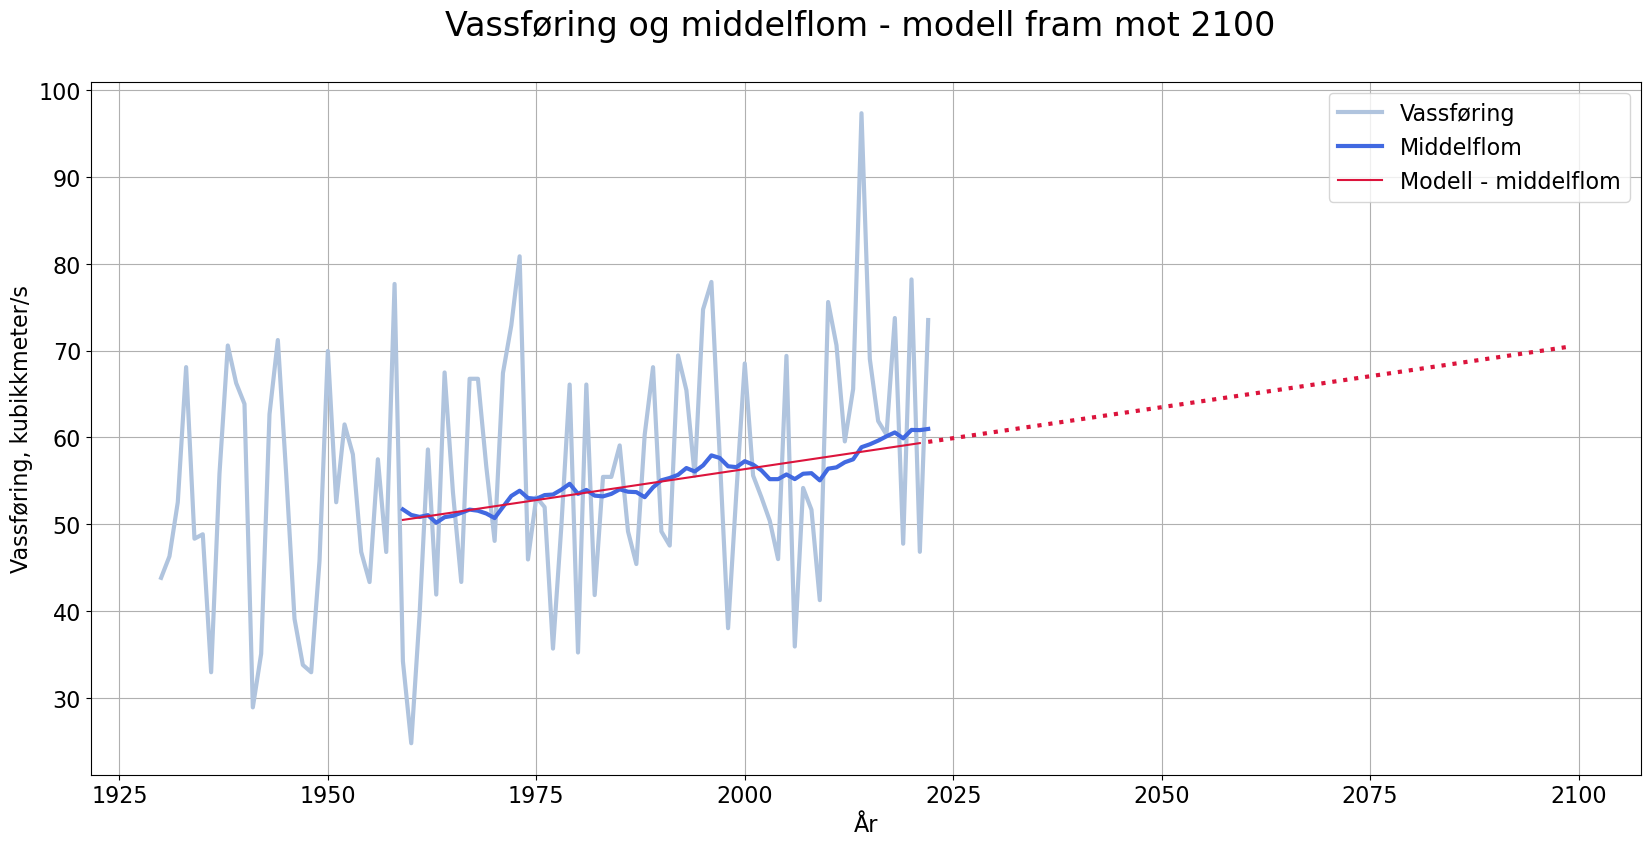

In [92]:
#| code-fold: true
maks_og_middelflom.plot(figsize = (20,9), 
                grid = True, 
                fontsize = 16, 
                linewidth = 3, 
                color = ["lightsteelblue", "royalblue"]
               )

plt.plot(x, f(x), 
         linewidth = 1.5, 
         label = "Modell - middelflom", 
         color = "crimson"
        )

# Plottar forlenginga av den lineære modellen
x2 = np.arange(2022, 2100)
plt.plot(x2, f(x2), ":", linewidth = 3, color = "crimson")

# pynting av plot
plt.title("Vassføring og middelflom - modell fram mot 2100 \n", fontsize = 24)
plt.legend(fontsize = 16)
plt.ylabel("Vassføring, kubikkmeter/s", fontsize = 16)
plt.xlabel("År", fontsize = 16)
#plt.savefig("Reinsnos - modellering av middelflom 2100.png", dpi = 300)
plt.show()